### FrozenLake - Tabular Q-Learning

In [2]:
import gym 
import collections
import time

import numpy as np
import pandas as pd
from plotnine import *
from mizani.formatters import comma_format, percent_format
import matplotlib.pyplot as plt
import seaborn as sns

from tensorboardX import SummaryWriter
from IPython.display import clear_output

pd.set_option('display.max.columns', 500)
plt.rcParams['figure.figsize'] = [3, 3]

### The Game:

<img src='Images/frozen_lake.gif' width='250' style='float:left; margin:0px 50px 0px 0px'/>

- The world is from the so-called grid world category:
- Agent lives in a grid of size 4×4, can move in four directions: up, down, left, and right
- Agent always starts at a top-left position, and its goal is to reach the bottom-right
- There are holes in the fixed cells of the grid that if hit, episode ends and your reward is zero. 
- If agent reaches the destination cell, reward of 1.0 and the episode ends
- The world is slippery, so the agent's actions do not always turn out as expected¨
- There is a 33% chance that it will slip to the right or to the left. 
- If you want the agent to move left, for example, there is a 33% probability that it will, indeed, move left, a 33% chance that it will end up in the cell above, and a 33% chance that it will end up in the cell below. 
- As you will see at the end of the section, this makes progress difficult.

In [3]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')

In [4]:
env.observation_space

Discrete(16)

Observation space is the discrete range from 0 to 15, i.e. the position in the grid. This will have to be one-hot encoded for the neural network from the Cartpole example.

In [101]:
env.action_space

Discrete(4)

Action space is discrete range from 0 to 3, i.e. up, right, down or left.

In [12]:
env.reset()

(0, {'prob': 1})

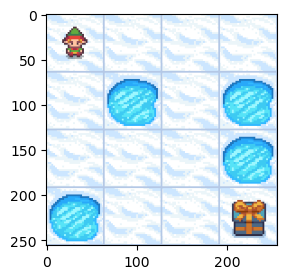

In [13]:
plt.imshow(env.render())

Looks like this when fallen in:

<img src="Images/fallen_in.png" width=300>

### How does a `defaultdict` work?

`defaultdict` doesn't throw KeyError if element is not found. Instead, a new entry is created. The type of this new entry is given by the argument of defaultdict:`

In [14]:
somedict = collections.defaultdict(float)
somedict[0] = 'example'
somedict[1] = 'dict'
print(somedict[1])
print(somedict[2])

dict
0.0


In [15]:
somedict = collections.defaultdict(collections.Counter)
somedict[0] = 'example'
somedict[1] = 'dict'
print(somedict[1])
print(somedict[2])

dict
Counter()


As shown above, it just returns the default value for an unknown key.

### How does a `Counter()` Object work?

The Counter object is essentially a specialized dictionary that counts the occurrences of its elements. When you add elements to a Counter, it keeps track of the counts for each element. Here's an example:

In [16]:
c = collections.Counter()
c['cat'] += 1
c['dog'] += 1
c['cat'] += 1
c

Counter({'cat': 2, 'dog': 1})

In [17]:
c.items()

dict_items([('cat', 2), ('dog', 1)])

In [18]:
sum(c.values()) # calculate total occurences

3

And in the Agent class, we have a counter in a `defaultdict` for any imaginable key combination of state and action there is. If we then use the second edge brackets with the state that we transitioned to, it will count the occurence +1 in the Counter's dictionary.

In [19]:
transits = collections.defaultdict(collections.Counter)
transits[(0, 0)][1]

0

In [20]:
transits[(0, 0)][1] += 1
transits[(0, 0)][1]

1

In [21]:
transits[(0, 0)][1] += 1
transits[(0, 0)][1]

2

This says: From state 0, using action 0, we landed in state 1. This happened to times, so we increment the counter two times.

### Defining the Agent 🤖

The agent is now not a Neural Network anymore, but a class that takes note of the
- rewards that were obtained,
- transitions to new states that were made and
- values of any given state (which is the expected value of the immediate reward and the discounted value of the next state, see Bellman update).

In [22]:
# ENV_NAME = 'FrozenLake-v1'
GAMMA = 0.9
ALPHA = 0.2
TEST_EPISODES = 500

In [23]:
class Agent:
    def __init__(self, ENV_NAME, DESC, RENDER_MODE, IS_SLIPPERY):
        # Initialise environment and get initial state
        self.env = gym.make(ENV_NAME, desc=DESC, render_mode=RENDER_MODE, is_slippery=IS_SLIPPERY)
        self.state, _ = self.env.reset()
        # Initialise the tables for rewards, transition probs and state values
        self.values = collections.defaultdict(float)

    def sample_env(self):
        '''
        Take one step in the environment (at random) and return the old
        state, the reward, flags and new state
        '''
        # Take a random action sampled from action space
        action = self.env.action_space.sample()
        old_state = self.state
        # Take a step and get new information
        new_state, reward, is_done, is_truncated, _ = self.env.step(action)
        # Either reset if Episode ended or continue next step
        if is_done or is_truncated:
            self.state, _ = self.env.reset()
        else:
            self.state = new_state
        return (old_state, action, reward, new_state)
        
    def best_value_and_action(self, state):
        '''
        Function is given a state and iterates over all actions to
        try and find the action that gives the highest value for the
        state/action pair with the given stsate. It then returns the
        best action given the state.
        '''
        best_action, best_value = None, None
        # for each action in the entire action space
        for action in range(self.env.action_space.n):
            # Get the value of the action and state pair right from the table
            action_value = self.values[(state, action)]
            # If best value is below the current action value
            if best_value is None or best_value < action_value:
                # then update the best value
                best_value = action_value
                # and make this action the new best action given the state
                best_action = action
        return best_value, best_action
    
    def value_update(self, s, a, r, next_s):
        '''
        Does the Bellman Approximation by linearly blending the old
        and the new value according to the Bellman update. Bellman update
        constitutes immediate reward + discounted value of the next state.
        '''
        # Get the highest value of the NextState/Action pair
        best_v, _ = self.best_value_and_action(next_s)
        new_val = r + GAMMA * best_v
        old_val = self.values[(s, a)]
        self.values[(s, a)] = old_val * (1-ALPHA) + new_val * ALPHA

        
    def play_episode(self, env):
        '''
        This method plays exactly one episode and returns the total
        reward of the episode. It does not continue to update the Q-values.
        '''
        # initialise reward of episode as nothing
        total_reward = 0.0
        # get initial observation
        state, _ = env.reset()
        while True:
            # Select the best action from the Q Table given the current state
            _, action = self.best_value_and_action(state)
            # Take the action
            new_state, reward, is_done, is_truncated, _ = env.step(action)
            # Add reward from step to episode reward
            total_reward += reward
            # if Episode is over, break the while loop
            if is_done or is_truncated:
                break
            # If not broken, then new state is the one gained from
            # the action that was taken
            state = new_state 
        # return the total reward of the episode every step?
        return total_reward
    
    def demonstrate_episodes(self, env, episodes):
        for episode in range(episodes):
            episode_reward = 0.0
            state, _ = env.reset()
            
            while True:
                _, action = self.best_value_and_action(state)
                # take a step
                next_state, reward, is_done, is_truncated, _ = env.step(action)
                episode_reward += reward
                state = next_state
                
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()

                if is_done or is_truncated:
                    break

            print(f"Episode {episode + 1}: {episode_reward} reward")
            if episode_reward == 1:
                print("SUCCESS")
            else:
                print("FAIL")

            time.sleep(1)

_**__init__(self, ENV_NAME)**_:
***
This method defines
- the environment that the agent is trained on (not the environment that it is tested in)
- the initial state
- the Q-Table as a defaultdict which returns 0.0 for non-existing keys

_**sample_env(self)**_:
***
This method
- samples a random action from the environment
- takes a step in the environment with the random action
- returns a tuple (old state, action, reward, new state)

_**best_value_and_action(self, state)**_:
***
This method
- takes in a state
- loops through all actions in the action space and
- gets the current value of state/action pair
- compares if the Q value is higher than for all other actions given the statge
- returns the tuple (best value, best action) for the given state

_**value_update(self, s, a, r, next_s)**_:
***
This method
- gets the highest value of the state that was transitioned to
- calculates the bellman update of reward + discounted value of next state for old state
	- next state is the state we're currently in, so looks back and updates Q-value of old state
- gets the previous Q-value of the old state
- linearly blends the old and new value according to learning rate alpha in the Q-Table

_**play_episode(self, env)**_:
***
This method plays exactly one episode and returns the total reward of the episode. It does not continue to update the Q-values. Importantly, the environment is a test environment, i.e. it is not the environment that the agent learns from, which is instead defined in the init method. The test environment is defined outside of the agent class.
- sets total reward to zero
- gets initial state of the env
- for each step, it gets the best possible action from this state according to Q-Values
- takes the best action, adds step reward to episode reward
- breaks if episode is over
- then returns episode reward

_**demonstrate_episodes(self, env, episodes)**_:
***
This function was written by me to visualise the trained agent playing in the environment.

***

In the next step, let's train the agent:

In [114]:
# Training the agent:
agent = Agent(ENV_NAME='FrozenLake-v1', DESC=None, IS_SLIPPERY=True, RENDER_MODE='rgb_array')

# making an environment that I will test in
test_env = gym.make('FrozenLake-v1', render_mode='rgb_array')

iter_no = 0
best_reward = 0.0
# Continue playing until some break condition is met
while True:
    iter_no += 1
    # sample from the environment 
    # old state, action, reward, new state
    s, a, r, next_s = agent.sample_env()
    # update the value in the Q Table according to the Bellman update
    # and respecting the learning rate as defined by the function
    agent.value_update(s, a, r, next_s)

    # Play N Test episodes and calculate the average reward over these episodes
    # Therefore, set reward to zero at first
    reward = 0.0
    # Test the agent every 100 training iterations
    if iter_no % 100 == 0:
        # Run N Test Episodes and add up the rewards
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        # Calculate average reward over the test episodes
        reward /= TEST_EPISODES

    # Update if the new average reward is better than previous best
    if reward > best_reward:
        print(f"Iteration {iter_no}: Best reward updated {best_reward:.2f} -> {reward:.2f}")
        best_reward = reward
    # break condition: If the average test reward is higher than this level
    # consider the agent trained and end the training
    if reward >= 0.76:
        print(f"Solved in {iter_no} iterations!")
        break

Iteration 2800: Best reward updated 0.00 -> 0.02
Iteration 2900: Best reward updated 0.02 -> 0.06
Iteration 3000: Best reward updated 0.06 -> 0.06
Iteration 3100: Best reward updated 0.06 -> 0.13
Iteration 3200: Best reward updated 0.13 -> 0.15
Iteration 3300: Best reward updated 0.15 -> 0.16
Iteration 4900: Best reward updated 0.16 -> 0.17
Iteration 5000: Best reward updated 0.17 -> 0.17
Iteration 6300: Best reward updated 0.17 -> 0.17
Iteration 6500: Best reward updated 0.17 -> 0.21
Iteration 6600: Best reward updated 0.21 -> 0.26
Iteration 6700: Best reward updated 0.26 -> 0.59
Iteration 30000: Best reward updated 0.59 -> 0.60
Iteration 30500: Best reward updated 0.60 -> 0.66
Iteration 35400: Best reward updated 0.66 -> 0.72
Iteration 35900: Best reward updated 0.72 -> 0.74
Iteration 101500: Best reward updated 0.74 -> 0.75
Iteration 116000: Best reward updated 0.75 -> 0.76
Iteration 163700: Best reward updated 0.76 -> 0.76
Solved in 163700 iterations!


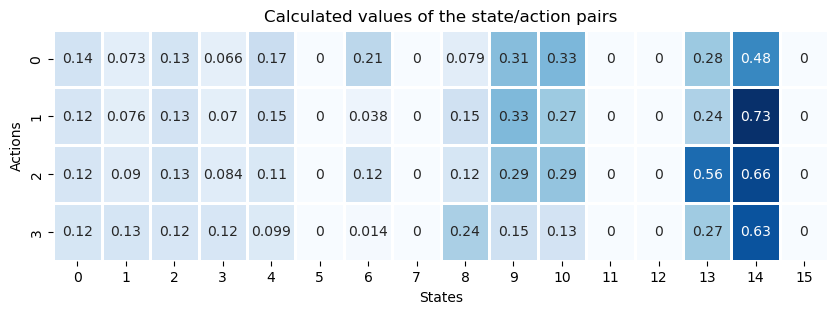

In [115]:
plt.rcParams['figure.figsize'] = [10, 3]

state_action_values = (pd.DataFrame(agent.values.items(),
                                    columns=['State/Action', 'Value'])
                       .assign(State=lambda x: x['State/Action'].apply(lambda r: r[0]),
                               Action=lambda x: x['State/Action'].apply(lambda r: r[1]))
                       )

# pivot the data to create a matrix
mat = state_action_values.pivot(index='Action', columns='State', values='Value')

# create the plot using seaborn heatmap
ax = sns.heatmap(mat, cmap='Blues', annot=True, square=False,
                 linewidths=1, cbar=False)
ax.set_title("Calculated values of the state/action pairs")

# set axis labels
plt.xlabel('States')
plt.ylabel('Actions')

# show the plot
plt.show()

0: LEFT
1: DOWN
2: RIGHT
3: UP

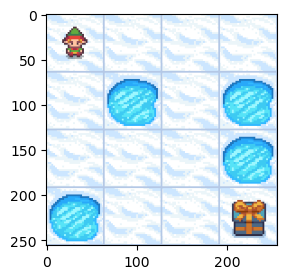

In [116]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.imshow(env.render())

### Letting the trained agent play 10,000 episodes

Then visualise the running win rate to see if the agent's performance holds up over a longer time.

In [121]:
test_results = []
for _ in range(10000):
    reward = agent.play_episode(test_env)
    test_results.append(reward)

test_episodes_10k = ((pd.DataFrame({'episode': np.arange(1, 10000 + 1),
                                    'results': test_results})
                      .assign(results=lambda x: x['results'].rolling(500).mean())
                      .dropna()
                      .reset_index(drop=True)
                      ))

mean_10k = test_episodes_10k.results.mean()

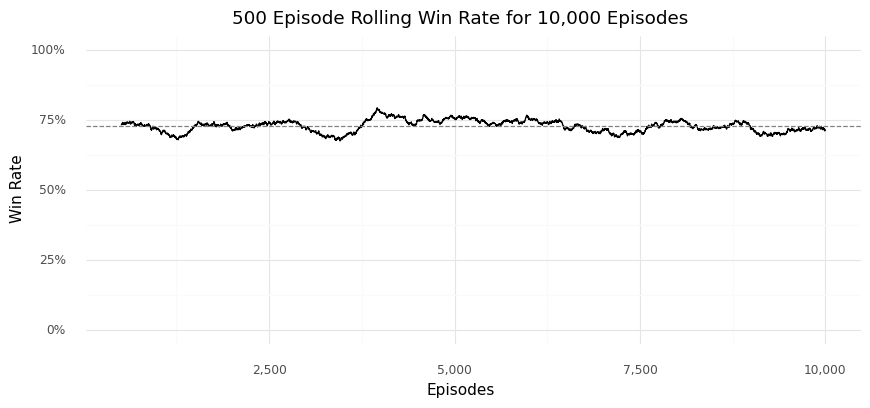

<ggplot: (124452748718)>

In [135]:
(
    ggplot(data=test_episodes_10k,
            mapping=aes(x='episode', y='results')) +

    geom_line() +
    labs(title='500 Episode Rolling Win Rate for 10,000 Episodes',
         y='Win Rate', x='Episodes') +
    geom_hline(yintercept = mean_10k, linetype='dashed', colour='grey') +
    scale_x_continuous(labels=comma_format()) +
    scale_y_continuous(limits=[0, 1],
                       labels=percent_format()) +
    theme_minimal() +
    theme(figure_size=[10,4])
)


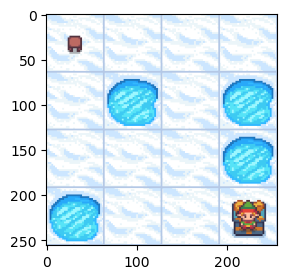

Episode 1: 1.0 reward
SUCCESS


In [137]:
agent.demonstrate_episodes(test_env, 1)

### Training the Agent in a custom terrain

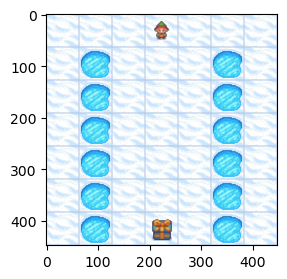

In [138]:
test_env = gym.make('FrozenLake-v1', desc=["FFFSFFF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFGFHF"],
                    render_mode='rgb_array', is_slippery=True)

agent = Agent(ENV_NAME='FrozenLake-v1', DESC=["FFFSFFF",
                                              "FHFFFHF",
                                              "FHFFFHF",
                                              "FHFFFHF",
                                              "FHFFFHF",
                                              "FHFFFHF",
                                              "FHFGFHF"],
              RENDER_MODE='rgb_array', IS_SLIPPERY=True)

test_env.reset()
plt.imshow(test_env.render())

In [139]:
iter_no = 0
best_reward = 0.0
while True:
    iter_no += 1
    # sample from the env
    s, a, r, next_s = agent.sample_env()
    # update the value in the Q Table
    agent.value_update(s, a, r, next_s)

    reward = 0.0

    # Test the agent every 100 training iterations
    if iter_no % 100 == 0:
        # Run N Test Episodes and add up the rewards
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        # Calculate average reward over the test episodes
        reward /= TEST_EPISODES

    # Update if the new average reward is better than all previous
    if reward > best_reward:
        print(f"Iteration {iter_no}: Best reward updated {best_reward:.2f} -> {reward:.2f}")
        best_reward = reward
    if reward >= 0.93:
        print(f"Solved in {iter_no} iterations!")
        break

Iteration 100: Best reward updated 0.00 -> 0.00
Iteration 200: Best reward updated 0.00 -> 0.01
Iteration 300: Best reward updated 0.01 -> 0.01
Iteration 800: Best reward updated 0.01 -> 0.03
Iteration 900: Best reward updated 0.03 -> 0.09
Iteration 1900: Best reward updated 0.09 -> 0.11
Iteration 2000: Best reward updated 0.11 -> 0.20
Iteration 2400: Best reward updated 0.20 -> 0.44
Iteration 12000: Best reward updated 0.44 -> 0.48
Iteration 12100: Best reward updated 0.48 -> 0.52
Iteration 13300: Best reward updated 0.52 -> 0.54
Iteration 18200: Best reward updated 0.54 -> 0.54
Iteration 18400: Best reward updated 0.54 -> 0.59
Iteration 19500: Best reward updated 0.59 -> 0.59
Iteration 28100: Best reward updated 0.59 -> 0.73
Iteration 29200: Best reward updated 0.73 -> 0.74
Iteration 29500: Best reward updated 0.74 -> 0.78
Iteration 29900: Best reward updated 0.78 -> 0.84
Iteration 34600: Best reward updated 0.84 -> 0.84
Iteration 34800: Best reward updated 0.84 -> 0.85
Iteration 349

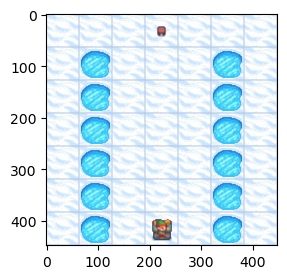

Episode 1: 1.0 reward
SUCCESS


In [140]:
agent.demonstrate_episodes(test_env, 1)

Problem: There is a timeout (how many steps, I don't know), which means that it's not a question of time until the thing is solved with certainty, but there is a probability <1 that it is solved in time before the timeout. Therefore, setting 500 episodes for testing is a sample size too large to be lucky enough to solve all before the timeout. Maybe test with 500 test episodes what is the upper ceiling?

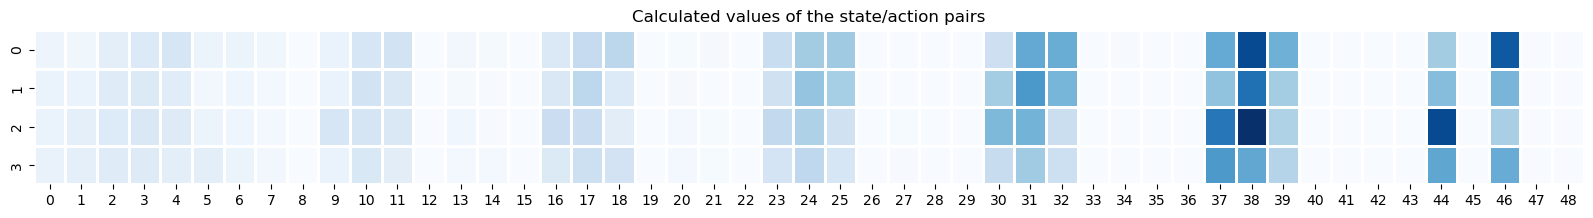

In [141]:
state_action_values = (pd.DataFrame(agent.values.items(),
                                    columns=['State/Action', 'Value'])
                       .assign(State=lambda x: x['State/Action'].apply(lambda r: r[0]),
                               Action=lambda x: x['State/Action'].apply(lambda r: r[1]))
                       )

state_action_values

plt.rcParams['figure.figsize'] = [20, 2]

# pivot the data to create a matrix
mat = state_action_values.pivot(index='Action', columns='State', values='Value')

# create the plot using seaborn heatmap
ax = sns.heatmap(mat, cmap='Blues', annot=False, square=False,
                 linewidths=1, cbar=False)
ax.set_title("Calculated values of the state/action pairs")

# set axis labels
plt.xlabel(None)
plt.ylabel(None)

# show the plot
plt.show()

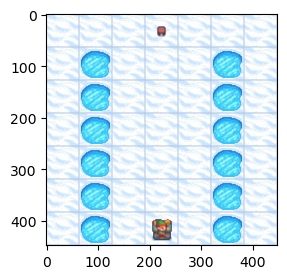

In [142]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.imshow(test_env.render())